# AllTissueJunctionAnalysis as a Notebook 

rMATS 3.2.5 was run on controlled access RNASeq files retrieved experiments stored in the Sequence Read Archive with controlled access managed by dbGaP.   The data were generated under the Gene Tissue Expression.

## rMATS RNASeq-MATS.py produces 10 different output types which get assembled into as type junction ID by sample ID matrices

### Alternative Splice Site Types are: (se, a3ss, a5ss, mxe, ri)

 This is input as ARGV1 into variable 'astype'

  * Skipped Exon events (se),
  * Alternative 3' splice site (a3ss),
  * Alternative 5' splice site (a5ss),
  * Mutually exclusive exon (mxe),
  * and retention intron (ri)

### There are two different kinds of junction counts

  * jc = junction counts - reads that cross the junction
  * jcec = junction counts plus reads on the target (such as included exon

### And the count type -- there are 5 types

  * inclusion levels (percent spliced in)
  * included junction counts (ijc)
  * skipped junction counts (sjc)
  * inclusion length (inclen)
  * skipped length (skiplen)

### function: fit_iso_tissue 

fit_iso_tissue expects the following input:

  * the tissue of interest (SMSTD) 
  * an ordered_merged_rmats -- which will be ordered to fit the count matrix
  * count matrix (inc or ijc & sjc merged)
  * splice type (a3ss, a5ss, mxe, ri or se)
  * junction_count type (jc or jcec)
  * count type (inc or the merged ijc,sjc)
  
### reordering to match annotations between count matrix and annotation matrix

Common problem is to match specifically the rows of an annotation matrix with the columns of a count matrix
`match` is the function that gives the re-ordering index required to accomplish this


## **NOTE**:

We assume that you have cloned the analysis repository and have `cd` into the parent directory. Before starting with the analysis make sure you have first completed the dependencies set up by following the instructions described in the **`dependencies/README.md`** document. All paths defined in this Notebook are relative to the parent directory (repository). Please close this Notebook and start again by following the above guidelines if you have not completed the aforementioned steps.

## rMATS-final-merged
the rmats-nf NextFlow was executed and the results released here:

## Loading dependencies

In [1]:
# temporary hack remove me when the dependencies are fixed
#
#install.packages("BiocManager")
#Sys.setenv(TAR = "/bin/tar")
#BiocManager::install(c('limma','edgeR', 'statmod'))
#install.packages(c('doParallel', 'doRNG', 'foreach', 'stringi', 'pheatmap'), repo = 'https://cran.r-project.org')
#devtools::install_github("ropensci/piggyback@87f71e8", upgrade="never")
#install.packages("runjags", repos = "https://cran.r-project.org")
#devtools::install_github("easystats/report")


In [2]:
library(limma)
library(piggyback)
library(multtest)
library(Biobase)
library(edgeR)
library(tibble)
#install.packages('R.utils')
library(R.utils)

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Loading required package: Biobase
Welcome to Bio

## Modeling

This analysis uses edgeR.  From the documentation, it is important to note that normalization takes the form of correction factors that enter into the statistical model. Such correction factors are usually computed internally by edgeR functions, but it is also possible for a user to supply them. The correction factors may take the form of scaling factors for the library sizes, such as computed by calcNormFactors, which are then used to compute the effective library sizes. 

Alternatively, gene-specific correction factors can be entered into the glm functions of edgeR as offsets. In the latter case, the offset matrix will be assumed to account for all normalization issues, including sequencing depth and RNA composition.

Note that normalization in edgeR is model-based, and the original read counts are not themselves transformed. This means that users should not transform the read counts in any way before inputing them to edgeR. For example, users should not enter RPKM or FPKM val- ues to edgeR in place of read counts. Such quantities will prevent edgeR from correctly estimating the mean-variance relationship in the data, which is a crucial to the statistical strategies underlying edgeR. Similarly, users should not add artificial values to the counts before inputing them to edgeR.

edgeR is not designed to work with estimated expression levels, for example as might be output by Cufflinks. 
edgeR can work with expected counts as output by RSEM, but raw counts are still preferred. 

As instructed by the software, we are using the raw counts as provided by rMATS.  The raw counts we are using in the model are `ijc` and `sjc`, the sample specific raw read counts as they align to the junctions of the `included exon (ijc)` and the junctions of the `excluded or skipped exon (sjc)` respectively.


Be sure to set your GITHUB_TOKEN, prior to downloading files

One suggestion is change it to your token and then run it then immediately change it back to this:

Sys.setenv(GITHUB_TOKEN = "your-very-own-github-token")

In [3]:
# devtools::install_github("ropensci/piggyback@87f71e8", upgrade="never")
#parameters for running the notebook as NextFlow

tissue_index <- 17

### Did you remember?
Did you remember to delete your private github token?  Now is a good time to do so, before you save your work and checkit in inadvertantly....

In [4]:
if (!("SraRunTable.txt.gz" %in% list.files("../data/"))) {
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "TheJacksonLaboratory/sbas", 
        file = "SraRunTable.txt.gz",
        tag  = "GTExV8.v1.0", 
        dest = "../data/")
    
    message("Loading metadata from SraRunTable.txt.gz ../data/gtex.rds ..\n")   
    metadata <- data.table::fread("../data/SraRunTable.txt.gz")
    message("done!")
} else {
    message("Loading metadata from SraRunTable.txt.gz ../data/gtex.rds ..\n")   
    metadata <- data.table::fread("../data/SraRunTable.txt.gz")
    message("done!\n")
}

if (!("rmats_final.se.jc.ijc.txt.gz" %in% list.files("../data/"))) {    
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.se.jc.ijc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = "../data/")
    message("Loading ijc counts from rmats_final.se.jc.ijc.txt.gz ../data/gtex.rds ..\n")   
    ijc.iso.counts.mem <- data.table::fread("../data/rmats_final.se.jc.ijc.txt.gz")
    message("done!\n")
} else {
    message("Loading ijc counts from rmats_final.se.jc.ijc.txt.gz ../data/gtex.rds ..\n")   
    ijc.iso.counts.mem <- data.table::fread("../data/rmats_final.se.jc.ijc.txt.gz")
    message("done!\n")    
}

if (!("rmats_final.se.jc.sjc.txt.gz" %in% list.files("../data/"))) {
    message("Downloading rmats_final.se.jc.sjc.txt.gz")
    piggyback::pb_download(
        show_progress = TRUE,
        repo = "adeslatt/sbas_test", 
        file = "rmats_final.se.jc.sjc.txt.gz",
        tag  = "rMATS.3.2.5.GTEx.V8.final_matrices", 
        dest = "../data/")
    message("Loading sjc counts from rmats_final.se.jc.sjc.txt.gz ../data/gtex.rds ..\n")   
    sjc.iso.counts.mem <- data.table::fread("../data/rmats_final.se.jc.sjc.txt.gz")
    message("done!\n")    

} else {
    message("Loading sjc counts from rmats_final.se.jc.sjc.txt.gz ../data/gtex.rds ..\n")   
    sjc.iso.counts.mem <- data.table::fread("../data/rmats_final.se.jc.sjc.txt.gz")
    message("done!\n")        
}

if (!("gtex.rds" %in% list.files("../data/"))) {
    message("Downloading and loading obj with GTEx v8 with 'yarn::downloadGTExV8()'\n")
    obj <- yarn::downloadGTExV8(type='genes',file='../data/gtex.rds')
    message("Done!\n")

} else {
# Load with readRDS() if gtex.rds available in data/
    message("Loading obj GTEx v8 rds object with readRDS from ../data/gtex.rds ..\n")   
    obj <- readRDS(file = "../data/gtex.rds")
    message("Done!\n")
    message("Generating sha256sum for gtex.rds ..\n")    
    message(system("sha256sum ../data/gtex.rds", intern = TRUE))
    message("Done!\n")
} 
if (! (file.exists("../data/fromGTF.tar.gz"))) {
    system("mkdir -p ../data", intern = TRUE)
    message("Fetching fromGTF.tar.gz from GitHub ..")
    # Download archive from GitHub release with tag "dge"
    piggyback::pb_download(file = "fromGTF.tar.gz",
                           dest = "../data",
                           repo = "adeslatt/sbas_gtf",
                           tag  = "rMATS.3.2.5.gencode.v30",
                           show_progress = TRUE)
    message("Done!\n")
    message("Decompressing fromGTF.tar.gz into ../data")
    system("mkdir -p ../data && tar xvfz ../data/fromGTF.tar.gz -C ../data", intern = TRUE)
    message("Done!\n")
    message("Decompressing fromGTF.*.txt.gz into ../data")
    system("gunzip  ../data/fromGTF*.txt.gz ", intern = TRUE)
    message("Done!\n")
    message("Reading fromGTF.SE.txt into fromGTF.SE")    
    fromGTF.SE <- read.table("../data/fromGTF.SE.txt", header=TRUE)
    message("Done!\n")
} else {
        message("Reading fromGTF.SE.txt into fromGTF.SE")    
        fromGTF.SE <- read.table("../data/fromGTF.SE.txt", header=TRUE)
        message("Done!\n")
    
}

Loading metadata from SraRunTable.txt.gz ../data/gtex.rds ..

done!

Loading ijc counts from rmats_final.se.jc.ijc.txt.gz ../data/gtex.rds ..

done!

Loading sjc counts from rmats_final.se.jc.sjc.txt.gz ../data/gtex.rds ..

done!

Loading obj GTEx v8 rds object with readRDS from ../data/gtex.rds ..

Done!

Generating sha256sum for gtex.rds ..

18e2c7a83c98dcf59ddab53e1281923979d49da6ea3acb68114c5a44057c57bc  ../data/gtex.rds
Done!

Reading fromGTF.SE.txt into fromGTF.SE
Done!



## Quality control, preprocessing of data 

We observed above that our phenotype data have 2 more observations than our expression data. Let's inspect what these samples are:

In [ ]:
tail (pData(obj),2)
dim(pData(obj))
dim(exprs(obj))
dim(obj)
sample_names=as.vector(as.character(colnames(exprs(obj))))
pheno_sample_names=as.vector(as.character(rownames(pData(obj))))
length(pheno_sample_names)
length(sample_names)

if (length(pheno_sample_names) > length(sample_names)) {
    superset <- pheno_sample_names
    subset   <- sample_names    
} 

if (length(pheno_sample_names) < length(sample_names)) {
    superset <- sample_names
    subset   <- pheno_sample_names   
} 

non_overlaps <- setdiff( superset, subset)

message("The non-overlapping IDs between pheno and count data are:\n\n", 
        paste(non_overlaps, collapse = "\n") )
logical_match_names=superset %in% subset
length(logical_match_names)
table(logical_match_names)
pData(obj) <- (pData(obj)[logical_match_names==TRUE,])
dim(pData(obj))
dim(obj)

### keep only those values for which we have phenotype data 
Samples were resequenced, which is shown since we have the previous step saw no reduction in information - but we are using the yarn function to correct for errors in the GTEx data set.

To deal with this, we make the metadata unique per sample, rather than unique per run -- there are a little over 100 runs that are more than one sequencing run for a sample.

There are in fact 69 samples which have more than 1 run, 67 samples that have 3 sequencing runs and 2 samples that have 2 sequencing runs.

### Now we need to reduce the metadata to the unique samples
We will use the first occurance of the sample, got the idea from here https://stackoverflow.com/questions/19944334/extract-rows-for-the-first-occurrence-of-a-variable-in-a-data-frame

In [5]:
metadata$SAMPID   <- gsub('-','\\.',metadata$'Sample Name')
pData(obj)$SAMPID <- gsub('-','\\.',pData(obj)$SAMPID)

length(unique(pData(obj)$SAMPID))
length(unique(metadata$SAMPID))
length(metadata$SAMPID)

[1] 17383

[1] 14224

[1] 24667

### Name the rows by the SE Junction ID

Name the rows with the junction id column and then make the matrix just about the counts.
Adjust the matrix, preparing them to be pure count matrices

In [6]:
# preserve junction id as rowname
rownames(ijc.iso.counts.mem) <- ijc.iso.counts.mem$ID
rownames(sjc.iso.counts.mem) <- sjc.iso.counts.mem$ID

# and remove the id to have a data matrix
ijc.iso.counts.mem2  <- ijc.iso.counts.mem[,-1]
sjc.iso.counts.mem2  <- sjc.iso.counts.mem[,-1]

dim(ijc.iso.counts.mem2)
dim(sjc.iso.counts.mem2)

[1] 42611  8673

[1] 42611  8673

### Line up the run names in the metadata with the count matrices
We need to do two things, one refer to only those runs that we have appropriate metadata for and two make sure the order of both are in sync.  First, we make sure that both the metadata runs and the ijc, sjc counts are the same

In [7]:
ijc_run_names <- as.vector(as.character(colnames(ijc.iso.counts.mem2)))
run_names     <- as.vector(as.character(metadata$Run))

non_overlaps <- setdiff( ijc_run_names, run_names)

message("The non-overlaping IDs between pheno and count data are:\n\n", 
        paste(length(non_overlaps), collapse = "\n") )

ijc_in_metadata =run_names %in% ijc_run_names

length(ijc_in_metadata)
table(ijc_in_metadata)

reduced_metadata <- metadata[ijc_in_metadata==TRUE,]

ijc_run_names      <- as.vector(as.character(colnames(ijc.iso.counts.mem2)))
reduced_run_names  <- as.vector(as.character(reduced_metadata$Run))

non_overlaps <- setdiff( ijc_run_names, reduced_run_names)

message("The non-overlapping IDs between ijc, sjc count matrix and the reduced_metadata are:\n\n", 
        paste(length(non_overlaps), collapse = "\n") )

runs_in_ijc  <- ijc_run_names %in% reduced_run_names 
table(runs_in_ijc)
length(runs_in_ijc)

ijc.iso.counts.mem3 <- data.matrix(ijc.iso.counts.mem2)
sjc.iso.counts.mem3 <- data.matrix(sjc.iso.counts.mem2)
dim(ijc.iso.counts.mem3)
dim(sjc.iso.counts.mem3)

ijc.iso.counts.mem3 <- ijc.iso.counts.mem3[,runs_in_ijc==TRUE]
sjc.iso.counts.mem3 <- sjc.iso.counts.mem3[,runs_in_ijc==TRUE]

dim(ijc.iso.counts.mem3)
dim(sjc.iso.counts.mem3)
dim(reduced_metadata)

The non-overlaping IDs between pheno and count data are:

0


[1] 24667

ijc_in_metadata
FALSE  TRUE 
15994  8673 

The non-overlapping IDs between ijc, sjc count matrix and the reduced_metadata are:

0


runs_in_ijc
TRUE 
8673 

[1] 8673

[1] 42611  8673

[1] 42611  8673

[1] 42611  8673

[1] 42611  8673

[1] 8673   80

###  Order ijc and sjc columns in the same order as the metadata Run order

Using tibble library, we can rearrange the columns as the column name.  

In [8]:
metadata_runnames    <- as.character(reduced_metadata$Run)

ijc.iso.counts.mem4  <- as_tibble(ijc.iso.counts.mem3)
sjc.iso.counts.mem4  <- as_tibble(sjc.iso.counts.mem3)

ijc.iso.counts.mem4  <- ijc.iso.counts.mem4[,c(metadata_runnames)]
sjc.iso.counts.mem4  <- sjc.iso.counts.mem4[,c(metadata_runnames)]

dim(ijc.iso.counts.mem4)
dim(sjc.iso.counts.mem4)
dim(reduced_metadata)


[1] 42611  8673

[1] 42611  8673

[1] 8673   80

### Removing 11IL0...

Remove samples that match '11IL0' from the ijc, sjc and metadata files using the logical grep, grepl

In [9]:
metadata_SAMPID      <- as.character(reduced_metadata$SAMPID)
keep_metadata <- (!grepl('11ILO',reduced_metadata$SAMPID))
table(keep_metadata)
ijc.iso.counts.mem4 <-ijc.iso.counts.mem4 [                    ,keep_metadata==TRUE]
sjc.iso.counts.mem4 <-sjc.iso.counts.mem4 [                    ,keep_metadata==TRUE]
reduced_metadata2   <-reduced_metadata    [keep_metadata==TRUE,                    ]

dim(reduced_metadata2)
dim(ijc.iso.counts.mem4)
dim(sjc.iso.counts.mem4)

keep_metadata
FALSE  TRUE 
   12  8661 

[1] 8661   80

[1] 42611  8661

[1] 42611  8661

### Add the yarn metadata 
Join the yarn metadata with the metadata we have (there are redundant samples that have been sequenced multiple times).

In [10]:
# now that we have this reduced we can merge these together
metadata_pData <- dplyr::left_join(reduced_metadata2, pData(obj), by = "SAMPID")
dim(metadata_pData)
write.csv(metadata_pData,"../data/metadata_pData.csv")

[1] 8661  146

### exploration of the details

For each sample, we have ijc and sjc count data and demo
For exon skipping events (SE), we have 42,611 non-zero junction IDs the (first dimension of the ijc and sjc cout table) for the skipped exon event for breast-Mammary Tissue, 191 individuals.  These are healthy individuals, and we are studying the impact of sex on the occurrence or non-occurance of specific alternative splicing events.   We explore the information we ahve about these junctions and create a construct, as_event, which accounts for the junction under exploration.

#### Exploring the ijc and sjc Count data 

We have two counts that are in many ways two sides of the same coin.  Both our the observational output and we wish to see how robust each are in their ability to separate out the samples to provide for us differentially expressed isoform events as measured by their counts.   Each junction is in a manner a specific marker to specific isoform events that may or may not be shared between the genders.   If there is significant results, then this is indicative of the separation achieved by isoform specific differentiation.   In our model we will use these in combination, it is important to see if they will yield the results we are looking for.

### What else could we add to our linear model
There are a couple of other items we can add to the mix, to make the data a bit more interesting
We will use the yarn SEX phenotype 1==male, 2==female, rather than the SRA sex phenotype.

In [11]:
table(metadata_pData$AGE)
table(metadata_pData$DTHHRDY)
table(metadata_pData$SMCENTER)
table(metadata_pData$SEX)
table(metadata_pData$sex)


20-29 30-39 40-49 50-59 60-69 70-79 
  652   576  1379  2638  2504   123 


   0    1    2    3    4 
4219  397 1942  437  780 


        B1     B1, A1         C1     C1, A1 C1, B1, A1         D1     D1, A1 
      4723        369       2150        513          0         60         57 


   1    2 
4998 2874 


female   male 
  3275   5386 

## Preparing the data further

### Keeping only tissues with sufficient number of samples for analysis

Using results from analysis of number of samples stored in `tissues.tsv` we keep only those that are members of this reduced tissue list.

In [12]:
tissue_reduction <- read.table(file="../assets/tissues.tsv", header=TRUE, sep="\t",
                               skipNul=FALSE, stringsAsFactors = FALSE)
colnames(tissue_reduction)  <- c("SMTSD","female","male","include","display_name")

# only include those tissues we wish to continue with
table(tissue_reduction$include)
tissue_reduction <- tissue_reduction[tissue_reduction$include==1,]


# reduced the expressionSet object to only those tissues we wish to keep
# create a matching tissue name to go with the expressionSet phenotype object
metadata_pData$tissue  <- factor(snakecase::to_snake_case(as.character(metadata_pData$SMTSD)))
tissue_reduction$SMTSD <- factor(snakecase::to_snake_case(as.character(tissue_reduction$SMTSD)))

length(levels(metadata_pData$tissue))
length(levels(tissue_reduction$SMTSD))

tissue_names_keep <- metadata_pData$tissue %in% tissue_reduction$SMTSD
table(tissue_names_keep)
length(tissue_names_keep)
dim(metadata_pData)

reduced_metadata_pData<-metadata_pData[tissue_names_keep==TRUE,]
dim(reduced_metadata_pData)

reduced_metadata_pData$tissue <- factor(reduced_metadata_pData$tissue)
levels(reduced_metadata_pData$tissue)
length(levels(reduced_metadata_pData$tissue))


 0  1 
11 39 

[1] 53

[1] 39

tissue_names_keep
FALSE  TRUE 
 1641  7020 

[1] 8661

[1] 8661  147

[1] 7020  147

[1] "adipose_subcutaneous"                 
 [2] "adipose_visceral_omentum"             
 [3] "adrenal_gland"                        
 [4] "artery_aorta"                         
 [5] "artery_coronary"                      
 [6] "artery_tibial"                        
 [7] "brain_caudate_basal_ganglia"          
 [8] "brain_cerebellar_hemisphere"          
 [9] "brain_cerebellum"                     
[10] "brain_cortex"                         
[11] "brain_frontal_cortex_ba_9"            
[12] "brain_hippocampus"                    
[13] "brain_hypothalamus"                   
[14] "brain_nucleus_accumbens_basal_ganglia"
[15] "brain_putamen_basal_ganglia"          
[16] "brain_spinal_cord_cervical_c_1"       
[17] "breast_mammary_tissue"                
[18] "cells_cultured_fibroblasts"           
[19] "cells_ebv_transformed_lymphocytes"    
[20] "colon_sigmoid"                        
[21] "colon_transverse"                     
[22] "esophagus_gastroesophageal_junction"  
[23] "esophagus_mucosa"                     
[24] "esophagus_muscularis"                 
[25] "heart_atrial_appendage"               
[26] "heart_left_ventricle"                 
[27] "liver"                                
[28] "lung"                                 
[29] "muscle_skeletal"                      
[30] "nerve_tibial"                         
[31] "pancreas"                             
[32] "pituitary"                            
[33] "skin_not_sun_exposed_suprapubic"      
[34] "skin_sun_exposed_lower_leg"           
[35] "small_intestine_terminal_ileum"       
[36] "spleen"                               
[37] "stomach"                              
[38] "thyroid"                              
[39] "whole_blood"

[1] 39

### realign count matrices with metadata
one more time realign with tibble assist

In [13]:
reduced_metadata_pData_runnames    <- as.character(reduced_metadata_pData$Run)

ijc.iso.counts.mem5  <- as_tibble(ijc.iso.counts.mem4)
sjc.iso.counts.mem5  <- as_tibble(sjc.iso.counts.mem4)

ijc.iso.counts.mem5  <- ijc.iso.counts.mem5[,c(reduced_metadata_pData_runnames)]
sjc.iso.counts.mem5  <- sjc.iso.counts.mem5[,c(reduced_metadata_pData_runnames)]

dim(ijc.iso.counts.mem5)
dim(sjc.iso.counts.mem5)
dim(reduced_metadata_pData)


[1] 42611  7020

[1] 42611  7020

[1] 7020  147

### Keeping only shared male female tissues
We need to remove the tissues that are not shared by males and females, we do this by finding the intersection of the tissue lists.

In [14]:

# SEX is coded 1 == Male
#              2 == Female
sex = factor(reduced_metadata_pData$SEX)
sex2 <- ifelse(sex == 1,'male','female')
table(sex)
table(sex2)

male_tissues_true   <- sex2 == "male"
female_tissues_true <- sex2 == "female"

tissue_list         <- reduced_metadata_pData$tissue
male_tissue_list    <- factor(reduced_metadata_pData$tissue[male_tissues_true   == TRUE])
female_tissue_list  <- factor(reduced_metadata_pData$tissue[female_tissues_true == TRUE])

male_female_tissue_list <- intersect(levels(male_tissue_list),levels(female_tissue_list))

keep = tissue_list %in% male_female_tissue_list

table(keep)


ijc_m_f         = ijc.iso.counts.mem5    [          ,keep==TRUE]
sjc_m_f         = sjc.iso.counts.mem5    [          ,keep==TRUE]
metadata_m_f    = reduced_metadata_pData [keep==TRUE,          ]
tissue_list_m_f = tissue_list            [keep==TRUE]

dim(ijc_m_f)
dim(sjc_m_f)
dim(metadata_m_f)
length(tissue_list_m_f)
tissue_list_m_f <- factor(tissue_list_m_f)
levels(tissue_list_m_f)
length(levels(tissue_list_m_f))
length(tissue_list_m_f)

sex
   1    2 
4519 2501 

sex2
female   male 
  2501   4519 

keep
TRUE 
7020 

[1] 42611  7020

[1] 42611  7020

[1] 7020  147

[1] 7020

[1] "adipose_subcutaneous"                 
 [2] "adipose_visceral_omentum"             
 [3] "adrenal_gland"                        
 [4] "artery_aorta"                         
 [5] "artery_coronary"                      
 [6] "artery_tibial"                        
 [7] "brain_caudate_basal_ganglia"          
 [8] "brain_cerebellar_hemisphere"          
 [9] "brain_cerebellum"                     
[10] "brain_cortex"                         
[11] "brain_frontal_cortex_ba_9"            
[12] "brain_hippocampus"                    
[13] "brain_hypothalamus"                   
[14] "brain_nucleus_accumbens_basal_ganglia"
[15] "brain_putamen_basal_ganglia"          
[16] "brain_spinal_cord_cervical_c_1"       
[17] "breast_mammary_tissue"                
[18] "cells_cultured_fibroblasts"           
[19] "cells_ebv_transformed_lymphocytes"    
[20] "colon_sigmoid"                        
[21] "colon_transverse"                     
[22] "esophagus_gastroesophageal_junction"  
[23] "esophagus_mucosa"                     
[24] "esophagus_muscularis"                 
[25] "heart_atrial_appendage"               
[26] "heart_left_ventricle"                 
[27] "liver"                                
[28] "lung"                                 
[29] "muscle_skeletal"                      
[30] "nerve_tibial"                         
[31] "pancreas"                             
[32] "pituitary"                            
[33] "skin_not_sun_exposed_suprapubic"      
[34] "skin_sun_exposed_lower_leg"           
[35] "small_intestine_terminal_ileum"       
[36] "spleen"                               
[37] "stomach"                              
[38] "thyroid"                              
[39] "whole_blood"

[1] 39

[1] 7020

### Keeping only chromosomes shared male female

The Y chromosome spans more than 59 million base pairs of DNA and represents almost 2 percent of the total DNA in cells. Each person normally has one pair of sex chromosomes in each cell. The Y chromosome is present in males, who have one X and one Y chromosome, while females have two X chromosomes. Since our analysis is on the comparative differences, we must eliminate chrY from our analyses.

To do so, we grab the annotation from the GTF file and remove those junctions that correspond to the genes on this chromosome

In [15]:
head(fromGTF.SE)
genes <- factor(fromGTF.SE$geneSymbol)
length(levels(genes))    

table(fromGTF.SE$chr)

keepAllJunctionsButChrY <- (fromGTF.SE$chr != "chrY")

table(keepAllJunctionsButChrY)
sum(table(keepAllJunctionsButChrY))

fromGTF_no_chrY <- fromGTF.SE[keepAllJunctionsButChrY,]
ijc_m_f_no_chrY <- ijc_m_f   [keepAllJunctionsButChrY,]
sjc_m_f_no_chrY <- sjc_m_f   [keepAllJunctionsButChrY,]

dim(ijc_m_f_no_chrY)
dim(sjc_m_f_no_chrY)
dim(fromGTF_no_chrY)


ijc_m_f_no_chrY <- data.matrix(ijc_m_f_no_chrY)
sjc_m_f_no_chrY <- data.matrix(sjc_m_f_no_chrY)

rownames(ijc_m_f_no_chrY) <- rownames(fromGTF_no_chrY)
rownames(sjc_m_f_no_chrY) <- rownames(fromGTF_no_chrY)

head(ijc_m_f_no_chrY)
head(fromGTF_no_chrY)
head(sjc_m_f_no_chrY)

,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,ENSG00000034152.18,MAP2K3,chr17,+,21287990,21288091,21284709,21284969,21295674,21295769
2,2,ENSG00000034152.18,MAP2K3,chr17,+,21303182,21303234,21302142,21302259,21304425,21304553
3,3,ENSG00000034152.18,MAP2K3,chr17,+,21295674,21295769,21287990,21288091,21296085,21296143
4,4,ENSG00000034152.18,MAP2K3,chr17,+,21295674,21295769,21287990,21288091,21298412,21298479
5,5,ENSG00000034152.18,MAP2K3,chr17,+,21295674,21295769,21284710,21284969,21296085,21296143
6,6,ENSG00000034152.18,MAP2K3,chr17,+,21295674,21295769,21284710,21284969,21298412,21298479


[1] 13390


 chr1 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19  chr2 chr20 
 3812  1458  2541  2540   663  1551  1544  2039  2538   742  2552  3547   939 
chr21 chr22  chr3  chr4  chr5  chr6  chr7  chr8  chr9  chrX  chrY 
  493   895  2938  1803  1863  1890  2053  1636  1313  1134   127 

keepAllJunctionsButChrY
FALSE  TRUE 
  127 42484 

[1] 42611

[1] 42484  7020

[1] 42484  7020

[1] 42484    11

,SRR821043,SRR821050,SRR821096,SRR821124,SRR821148,SRR821176,SRR821183,SRR821207,SRR821231,SRR821255,⋯,SRR615838,SRR615862,SRR615874,SRR615886,SRR615898,SRR615958,SRR615970,SRR615982,SRR617829,SRR617841
1,6,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0
2,771,69,106,129,133,232,553,100,127,126,⋯,39,84,116,56,6,161,47,146,213,58
3,15,0,1,0,3,4,2,0,1,1,⋯,0,0,0,1,0,1,0,0,2,1
4,8,1,0,0,0,0,1,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
5,20,0,2,0,5,6,4,0,2,1,⋯,0,0,0,1,0,1,0,2,2,1
6,13,1,1,0,2,2,3,0,2,0,⋯,0,0,0,0,0,0,0,2,0,0


,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,ENSG00000034152.18,MAP2K3,chr17,+,21287990,21288091,21284709,21284969,21295674,21295769
2,2,ENSG00000034152.18,MAP2K3,chr17,+,21303182,21303234,21302142,21302259,21304425,21304553
3,3,ENSG00000034152.18,MAP2K3,chr17,+,21295674,21295769,21287990,21288091,21296085,21296143
4,4,ENSG00000034152.18,MAP2K3,chr17,+,21295674,21295769,21287990,21288091,21298412,21298479
5,5,ENSG00000034152.18,MAP2K3,chr17,+,21295674,21295769,21284710,21284969,21296085,21296143
6,6,ENSG00000034152.18,MAP2K3,chr17,+,21295674,21295769,21284710,21284969,21298412,21298479


,SRR821043,SRR821050,SRR821096,SRR821124,SRR821148,SRR821176,SRR821183,SRR821207,SRR821231,SRR821255,⋯,SRR615838,SRR615862,SRR615874,SRR615886,SRR615898,SRR615958,SRR615970,SRR615982,SRR617829,SRR617841
1,5,0,1,0,2,2,2,0,1,0,⋯,0,0,0,0,0,0,0,2,0,0
2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
5,14,3,0,2,4,9,25,0,1,1,⋯,1,1,1,0,0,0,2,3,0,0
6,223,26,37,28,19,58,155,34,33,41,⋯,8,38,45,14,5,53,8,64,92,33


## Exploratory and Differential analysis as_event:ijc, sjc 

Differential Analysis (DE) was performed using voom (Law et.al., 2014) to transform junction counts (reads that were aligned to junctions when an exon is included - ijc, and reads that were aligned to junctions when the exon is excluded - sjc) with associated precision weights, followed by linear modeling and empirical Bayes procedure using limma.    In each tissue, the following linear regression model was used to detec secually dimorphic alternative splicing event expression: 

           y = B0 + B1 sex + epsilon (error)
           

where y is the included exon junction count expression; sex denotes the reported sex of the subject

## Differential analysis as_event (combined ijc and sjc)

Differential Analysis (DE) was performed using voom (Law et.al., 2014) to transform junction counts (reads that were aligned to junctions when an exon is included - ijc, and reads that were aligned to junctions when the exon is excluded - sjc) with associated precision weights, followed by linear modeling and empirical Bayes procedure using limma.    In each tissue, the following linear regression model was used to detec secually dimorphic alternative splicing event expression: 

           y = B0 + B1 sex + B2 as_event + B3 sex*as_event + epsilon (error)
           

where y is the alternative splicing event expression; sex denotes the reported sex of the subject, as_event represents the specific alternative splicing event - either included exon junction counts or skipped exon junction counts and their interaction terms.   Donor is added to our model as a blocking variable used in both the calculation of duplicate correlation as well as in the linear fit.

### Voom, limma's lmFit and eBayes

Using sample as a blocking variable, we are able to model the effects of the donor on the results, which improves the power.  This topic is discussed in biostars https://www.biostars.org/p/54565/.  And Gordon Smyth answers the question here https://mailman.stat.ethz.ch/pipermail/bioconductor/2014-February/057887.html.  The method of modeling is a random effects approach in which the intra-donor correlation is incorporated into the covariance matrix instead of the linear predictor.   And though as Gordon Smyth states both are good method and the twoway anova approach makes fewer assumptions, the random effects approach is statistically more powerful.  

We have a balanced design in which all donors receive all stimuli (which is really in healthy human donors, life and all of its factors!) Our measurement has so many points -- we are measuring in the skipped exon approach, 42,611 junctions!   It is not possible to encorporate those measurements into the linear predictor.  A two-way ANOVA approach is virtually as powerful as the random effects approach 
and hence is preferable as it makes fewer assumptions.

For an unbalanced design in which each donor receives only a subset of the stimula, the random effects approach is more powerful.

Random effects approach is equivalent to The first method is twoway anova, a generalization of a paired analysis.


In [16]:
print_exploratory_plots <- function (tissue_of_interest, fromGTF, tissue_list, ijc, sjc, metadata ) {

    fromGTF           <- fromGTF
    tissue_true       <- tissue_list == tissue_of_interest

    table(tissue_true)
    ijc_tissue        <- ijc      [                 ,tissue_true==TRUE]
    sjc_tissue        <- sjc      [                 ,tissue_true==TRUE]
    metadata_tissue   <- metadata [tissue_true==TRUE,                 ]

    ijc.df            <- as.data.frame(ijc_tissue)
    sjc.df            <- as.data.frame(sjc_tissue)    
    ijc.dm            <- data.matrix(ijc.df)
    sjc.dm            <- data.matrix(sjc.df)    
 
    sex       <- factor(metadata_tissue$sex,levels=c('male','female')) 
    design    <- model.matrix ( ~ sex )
    colnames(design) = c("intercept","sex")
    head(design)

    y_ijc <- DGEList(counts=ijc.dm, group = sex)
    y_ijc <- calcNormFactors(y_ijc, method="RLE")
    y_ijc_voom <- voom (y_ijc, design=design, plot=TRUE)

    fit_ijc <- lmFit(y_ijc_voom, design)
    fit_ijc <- eBayes(fit_ijc)

    ijc_sex_results                    <- topTable(fit_ijc, coef='sex', number=nrow(y_ijc_voom))
    ijc_sex_results_refined            <- ijc_sex_results$adj.P.Val <= 0.05 & abs(ijc_sex_results$logFC) >= abs(log2(1.5))
    ijc_sex_rnResults                  <- rownames(ijc_sex_results)
    ijc_sex_resultsAnnotations         <- fromGTF[ijc_sex_rnResults,]

    ijc_sex_results_refinedAnnotations <- ijc_sex_resultsAnnotations[ijc_sex_results_refined      ==TRUE,]
    dim (ijc_sex_results_refinedAnnotations)
    head(ijc_sex_results_refinedAnnotations)

    # geneSymbols are in the annotations 
    ijc_sex_geneSymbols               <- ijc_sex_resultsAnnotations$geneSymbol
    ijc_sex_refined_geneSymbols       <- ijc_sex_results_refinedAnnotations$geneSymbol
    length(ijc_sex_refined_geneSymbols)

    # adjust the rownames to be the geneSymbols rather than junction IDs
    ijc_sex_results_rn         <- paste(ijc_sex_geneSymbols,       ijc_sex_rnResults, sep="-")
    head(ijc_sex_results_rn)
    rownames(ijc_sex_results)       <- ijc_sex_results_rn

    length(ijc_sex_refined_geneSymbols)
    y_sjc <- DGEList(counts=sjc.dm, group = sex)
    y_sjc <- calcNormFactors(y_sjc, method="RLE")
    y_sjc_voom <- voom (y_sjc, design=design, plot=TRUE)

    fit_sjc <- lmFit(y_sjc_voom, design)
    fit_sjc <- eBayes(fit_sjc)

    sjc_sex_results                    <- topTable(fit_sjc, coef='sex', number=nrow(y_sjc_voom))
    sjc_sex_results_refined            <- sjc_sex_results$adj.P.Val <= 0.05 & abs(sjc_sex_results$logFC) >= abs(log2(1.5))
    sjc_sex_rnResults                  <- rownames(sjc_sex_results)
    sjc_sex_resultsAnnotations         <- fromGTF[sjc_sex_rnResults,]

    sjc_sex_results_refinedAnnotations <- sjc_sex_resultsAnnotations[sjc_sex_results_refined      ==TRUE,]
    dim (sjc_sex_results_refinedAnnotations)
    head(sjc_sex_results_refinedAnnotations)

    # geneSymbols are in the annotations 
    sjc_sex_geneSymbols               <- sjc_sex_resultsAnnotations$geneSymbol
    sjc_sex_refined_geneSymbols       <- sjc_sex_results_refinedAnnotations$geneSymbol
    length(sjc_sex_refined_geneSymbols)

    # adjust the rownames to be the geneSymbols rather than junction IDs
    sjc_sex_results_rn         <- paste(sjc_sex_geneSymbols,       sjc_sex_rnResults, sep="-")
    head(sjc_sex_results_rn)
    rownames(sjc_sex_results)       <- sjc_sex_results_rn

    length(sjc_sex_results_refined) 
   # print these exploratory plots for ijc and sjc alone
    Gender <- substring(sex,1,1)
    filename <- paste0(paste0("../pdf/", snakecase::to_snake_case(tissue_of_interest)),"-ijc-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y_ijc, labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
                gene.selection="common")
    dev.off()
    filename <- paste0(paste0("../pdf/", snakecase::to_snake_case(tissue_of_interest)),"-ijc-voom-MDSplot-100.pdf")
    pdf (filename)    
        plotMDS(y_ijc_voom, labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
                gene.selection="common")
    dev.off()

    fit_ijc <- lmFit(y_ijc_voom, design)
    fit_ijc <- eBayes(fit_ijc)
    ijc_sex_results          <- topTable(fit_ijc, coef='sex', number=nrow(y_ijc_voom))
    ijc_sex_results_refined  <- ijc_sex_results$adj.P.Val < 0.05 & abs(ijc_sex_results$logFC) > abs(log2(1.5))
    ijc_sex_rnResults       <- rownames(ijc_sex_results)

    filename <- paste0(paste0("../pdf/", snakecase::to_snake_case(tissue_of_interest)),"-sjc-MDSplot-100.pdf")
    pdf (filename)
           plotMDS(y_sjc, labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
                gene.selection="common")
    dev.off()
    filename <- paste0(paste0("../pdf/", snakecase::to_snake_case(tissue_of_interest)),"-sjc-voom-MDSplot-100.pdf")
    pdf (filename)    
          plotMDS(y_sjc_voom, labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
                gene.selection="common")
    dev.off()
        
    fit_sjc <- lmFit(y_sjc_voom, design)
    fit_sjc <- eBayes(fit_sjc)
        
    sjc_sex_results            <- topTable(fit_sjc, coef='sex', number=nrow(y_sjc_voom))
    sjc_sex_results_refined        <- sjc_sex_results$adj.P.Val <= 0.05 & abs(sjc_sex_results$logFC) >= abs(log2(1.5))
    sjc_sex_rnResults                  <- rownames(sjc_sex_results)
    sjc_sex_resultsAnnotations         <- fromGTF[sjc_sex_rnResults,]
    sjc_sex_results_refinedAnnotations <- sjc_sex_resultsAnnotations[sjc_sex_results_refined ==TRUE,]

    head(sjc_sex_resultsAnnotations)
    head(sjc_sex_results_refinedAnnotations)

    # geneSymbols are in the annotations 
    sjc_sex_geneSymbols               <- sjc_sex_resultsAnnotations$geneSymbol
    sjc_sex_refined_geneSymbols       <- sjc_sex_results_refinedAnnotations$geneSymbol

    # adjust the rownames to be the geneSymbols rather than junction IDs
    sjc_sex_results_rn         <- paste(sjc_sex_geneSymbols,       sjc_sex_rnResults, sep="-")
    head(sjc_sex_results_rn)    
    rownames(sjc_sex_results)       <- sjc_sex_results_rn
    sjc_sex_filename               = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_DGE_sjc_sex.csv',sep='')
    sjc_sex_refined_filename       = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_DGE_sjc_sex_refined.csv',sep='')
    sjc_sex_genesFilename          = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_sjc_sex_universe.txt',sep='')
    sjc_sex_refined_genesFilename       = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_sjc_sex_gene_set.txt',sep='')

    write.table(sjc_sex_results,            file = sjc_sex_filename      , row.names = T, col.names = T, quote = F, sep = ",")
    write.table(sjc_sex_results [sjc_sex_results_refined      ,], file = sjc_sex_refined_filename      , row.names = T, col.names = T, quote = F, sep = ",")
    write.table(sjc_sex_geneSymbols,        file = sjc_sex_genesFilename        , row.names = F, col.names = F, quote = F, sep = ",")
    write.table(sjc_sex_refined_geneSymbols,file = sjc_sex_refined_genesFilename, row.names = F, col.names = F, quote = F, sep = ",")
    
    sample_names <- as.character(colnames(ijc.dm))
    # we will add donor as a blocking parameter
    # rather than sample name -- we should use donor for real
    sample     <- factor(sample_names)
    
    donor    <- rep(sample, 2)

    
    ijc_names <- as.character(colnames(ijc.dm))
    sjc_names <- as.character(colnames(sjc.dm))
    sjc_names <- paste0(sjc_names,"-sjc")
    ijc_names <- paste0(ijc_names,"-ijc")

    colnames(ijc.dm) <- ijc_names
    colnames(sjc.dm) <- sjc_names

    as_matrix <- cbind(ijc.dm,sjc.dm)
    sex       <- c(rep(metadata_tissue$sex,2))
    sex       <- factor(sex, levels=c('male','female'))
    as_event  <- c(rep("ijc",dim(ijc.dm)[2]), rep("sjc", dim(sjc.dm)[2]))
    as_event  <- factor(as_event, levels=c("ijc", "sjc"))

    length(as_event)

    design    <- model.matrix( ~ sex + as_event + sex*as_event )

    colnames(design) <- c("intercept","sex","as_event","sex*as_event")

    dim(as_matrix)
    table(sex)
    table(as_event)
    head(design)

    y <- DGEList(counts=as_matrix, group = sex)
    y <- calcNormFactors(y, method="RLE")
    y_voom <- voom (y, design=design, plot = TRUE)

    # for testing comment this out for speed
    dup_cor <- duplicateCorrelation(y_voom$E, design=design, ndups=2, block=donor, weights=y$samples$norm.factors)
    dup_cor$consensus.correlation 
    
    y_dup_voom <- voom (y, design=design, plot = TRUE, block = donor, correlation = dup_cor$consensus.correlation)
    
    # print the combined exploratory plot
    filename <- paste0(paste0("../pdf/", snakecase::to_snake_case(tissue_of_interest)),"-y-ijc-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y[,c(1:dim(ijc.dm)[2])], labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
            gene.selection="common")
    dev.off()
    filename <- paste0(paste0("../pdf/", snakecase::to_snake_case(tissue_of_interest)),"-y-voom-ijc-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y_voom[,c(1:dim(ijc.dm)[2])], labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
            gene.selection="common")
    dev.off()
    filename <- paste0(paste0("../pdf/", snakecase::to_snake_case(tissue_of_interest)),"-y-dup-voom-ijc-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y_dup_voom[,c(1:dim(ijc.dm)[2])], labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
            gene.selection="common")
    dev.off()
    filename <- paste0(paste0("../pdf/", snakecase::to_snake_case(tissue_of_interest)),"-y-sjc-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y[,c((dim(ijc.dm)[2]+1)):(dim(ijc.dm)[2]+dim(sjc.dm)[2])], labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
            gene.selection="common")
    dev.off()
    filename <- paste0(paste0("../pdf/", snakecase::to_snake_case(tissue_of_interest)),"-y-voom-sjc-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y_voom[,c((dim(ijc.dm)[2]+1)):(dim(ijc.dm)[2]+dim(sjc.dm)[2])], labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
            gene.selection="common")
    dev.off()
    filename <- paste0(paste0("../pdf/", snakecase::to_snake_case(tissue_of_interest)),"-y-dup-voom-sjc-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y_dup_voom[,c((dim(ijc.dm)[2]+1)):(dim(ijc.dm)[2]+dim(sjc.dm)[2])], labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
            gene.selection="common")
    dev.off()

    # for testing comment this out for speed
    fit <- lmFit(y_dup_voom, design=design, block=donor, correlation = dup_cor$consensus.correlation)
    
    # and uncomment this to have the model fit to the design matrix
    #    fit <- lmFit(y_voom, design=design)
    fit <- eBayes(fit, robust=TRUE)    
    
    sex_as_events_results         <- topTable(fit, coef="sex*as_event", number=nrow(y_voom))
    sex_as_events_results_refined <- sex_as_events_results$adj.P.Val < 0.05 & abs(sex_as_events_results$logFC) > abs(log2(1.5))

    sex_results                   <- topTable(fit, coef="sex", number=nrow(y_voom))
    sex_results_refined           <- sex_results$adj.P.Val <= 0.05 & abs(sex_results$logFC) >= abs(log2(1.5))

    sex_as_events_rnResults <- rownames(sex_as_events_results)
    sex_rnResults           <- rownames(sex_results)
    head(sex_as_events_rnResults)
    head(ijc_sex_rnResults)
    head(sex_rnResults)
    head(fromGTF[sex_as_events_rnResults,])

    # use the junctionIDs to get the annotations
    sex_as_events_resultsAnnotations      <- fromGTF[sex_as_events_rnResults,]
    sex_resultsAnnotations                <- fromGTF[sex_rnResults,]
    ijc_sex_resultsAnnotations            <- fromGTF[ijc_sex_rnResults,]
    head(sex_as_events_resultsAnnotations)
    head(sex_resultsAnnotations)
    head(ijc_sex_resultsAnnotations)
    
    sex_as_events_results_refinedAnnotations<- sex_as_events_resultsAnnotations[sex_as_events_results_refined==TRUE,]
    sex_results_refinedAnnotations          <- sex_resultsAnnotations          [sex_results_refined          ==TRUE,]
    ijc_sex_results_refinedAnnotations      <- ijc_sex_resultsAnnotations      [ijc_sex_results_refined      ==TRUE,]
    head(sex_as_events_results_refinedAnnotations)
    head(sex_results_refinedAnnotations)
    head(ijc_sex_results_refinedAnnotations)

    # geneSymbols are in the annotations 
    sex_as_events_geneSymbols         <- sex_as_events_resultsAnnotations$geneSymbol
    sex_geneSymbols                   <- sex_resultsAnnotations$geneSymbol
    ijc_sex_geneSymbols               <- ijc_sex_resultsAnnotations$geneSymbol

    sex_as_events_refined_geneSymbols <- sex_as_events_results_refinedAnnotations$geneSymbol
    sex_refined_geneSymbols           <- sex_results_refinedAnnotations$geneSymbol
    ijc_sex_refined_geneSymbols       <- ijc_sex_results_refinedAnnotations$geneSymbol

    # adjust the rownames to be the geneSymbols rather than junction IDs
    sex_as_events_results_rn   <- paste(sex_as_events_geneSymbols, sex_as_events_rnResults, sep="-")
    sex_results_rn             <- paste(sex_geneSymbols,           sex_rnResults, sep="-")
    ijc_sex_results_rn         <- paste(ijc_sex_geneSymbols,       ijc_sex_rnResults, sep="-")
    head(sex_as_events_results_rn)
    head(sex_results_rn)
    head(ijc_sex_results_rn)
    rownames(sex_as_events_results) <- sex_as_events_results_rn
    rownames(sex_results)           <- sex_results_rn
    rownames(ijc_sex_results)       <- ijc_sex_results_rn
    
    sex_as_events_filename         = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_DGE_sex_as_events.csv')
    sex_filename                   = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_DGE_sex.csv',sep='')
    ijc_sex_filename               = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_DGE_ijc_sex.csv',sep='')

    sex_as_events_refined_filename = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_DGE_sex_as_events_refined.csv',sep='')
    sex_refined_filename           = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_DGE_sex_refined.csv',sep='')
    ijc_sex_refined_filename       = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_DGE_ijc_sex_refined.csv',sep='')

    sex_as_events_genesFilename    = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_sex_as_events_universe.txt',sep='')
    sex_genesFilename              = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_sex_universe.txt',sep='')
    ijc_sex_genesFilename          = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_ijc_sex_universe.txt',sep='')

    sex_as_events_refined_genesFilename = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_sex_as_events_gene_set.txt',sep='')
    sex_refined_genesFilename           = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_sex_gene_set.txt',sep='')
    ijc_sex_refined_genesFilename       = paste0(paste0('../data/',snakecase::to_snake_case(tissue_of_interest)),'_ijc_sex_gene_set.txt',sep='')

    write.table(sex_as_events_results, file = sex_as_events_filename, row.names = T, col.names = T, quote = F, sep = ",")
    write.table(sex_results,           file = sex_filename          , row.names = T, col.names = T, quote = F, sep = ",")
    write.table(ijc_sex_results,       file = ijc_sex_filename      , row.names = T, col.names = T, quote = F, sep = ",")

    write.table(sex_as_events_results[sex_as_events_results_refined,], file = sex_as_events_refined_filename, row.names = T, col.names = T, quote = F, sep = ",")
    write.table(sex_results          [sex_results_refined          ,], file = sex_refined_filename          , row.names = T, col.names = T, quote = F, sep = ",")
    write.table(ijc_sex_results      [ijc_sex_results_refined      ,], file = ijc_sex_refined_filename      , row.names = T, col.names = T, quote = F, sep = ",")

    write.table(sex_as_events_geneSymbols, file = sex_as_events_genesFilename, row.names = F, col.names = F, quote = F, sep = ",")
    write.table(sex_geneSymbols,           file = sex_genesFilename          , row.names = F, col.names = F, quote = F, sep = ",")
    write.table(ijc_sex_geneSymbols,       file = ijc_sex_genesFilename      , row.names = F, col.names = F, quote = F, sep = ",")

    write.table(sex_as_events_refined_geneSymbols,file = sex_as_events_refined_genesFilename, row.names = F, col.names = F, quote = F, sep = ",")
    write.table(sex_refined_geneSymbols,          file = sex_refined_genesFilename          , row.names = F, col.names = F, quote = F, sep = ",")
    write.table(ijc_sex_refined_geneSymbols,      file = ijc_sex_refined_genesFilename      , row.names = F, col.names = F, quote = F, sep = ",")

    return(0)
}

adipose_subcutaneous
adipose_visceral_omentum
adrenal_gland
artery_aorta
artery_coronary
artery_tibial
brain_caudate_basal_ganglia
brain_cerebellar_hemisphere
brain_cerebellum
brain_cortex
brain_frontal_cortex_ba_9
brain_hippocampus
brain_hypothalamus
brain_nucleus_accumbens_basal_ganglia
brain_putamen_basal_ganglia
brain_spinal_cord_cervical_c_1
breast_mammary_tissue
cells_cultured_fibroblasts
cells_ebv_transformed_lymphocytes
colon_sigmoid
colon_transverse
esophagus_gastroesophageal_junction
esophagus_mucosa
esophagus_muscularis
heart_atrial_appendage
heart_left_ventricle
liver
lung
muscle_skeletal
nerve_tibial
pancreas
pituitary
skin_not_sun_exposed_suprapubic
skin_sun_exposed_lower_leg
small_intestine_terminal_ileum
spleen
stomach
thyroid
whole_blood


[1] "breast_mammary_tissue"

[1] 39

[1] 7020

[1] 42484  7020

[1] 42484  7020

[1] 7020  147

[1] 42484    11

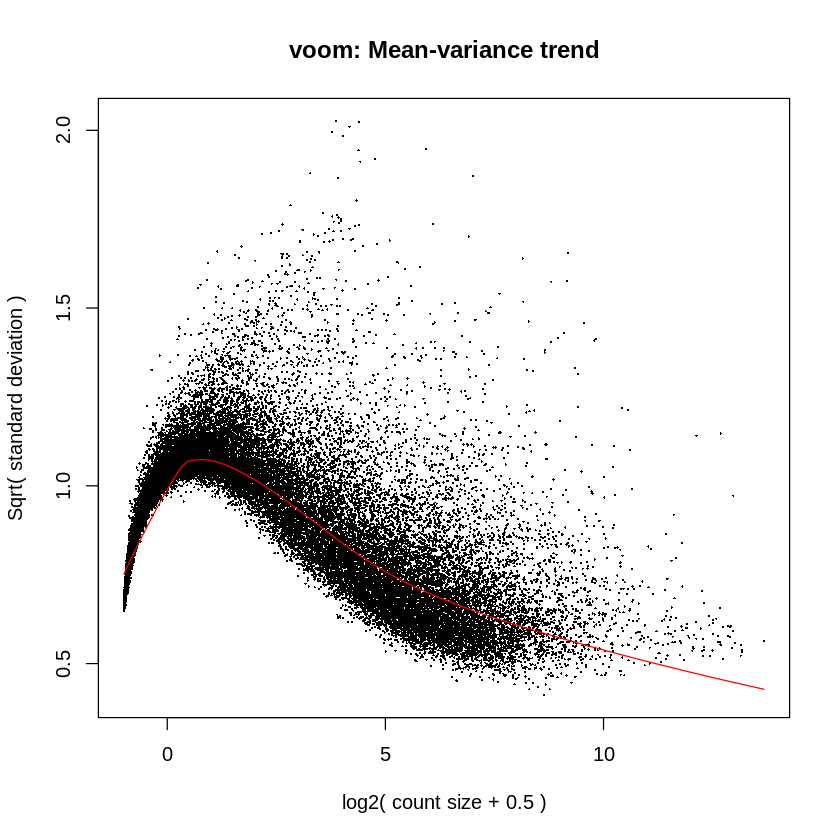

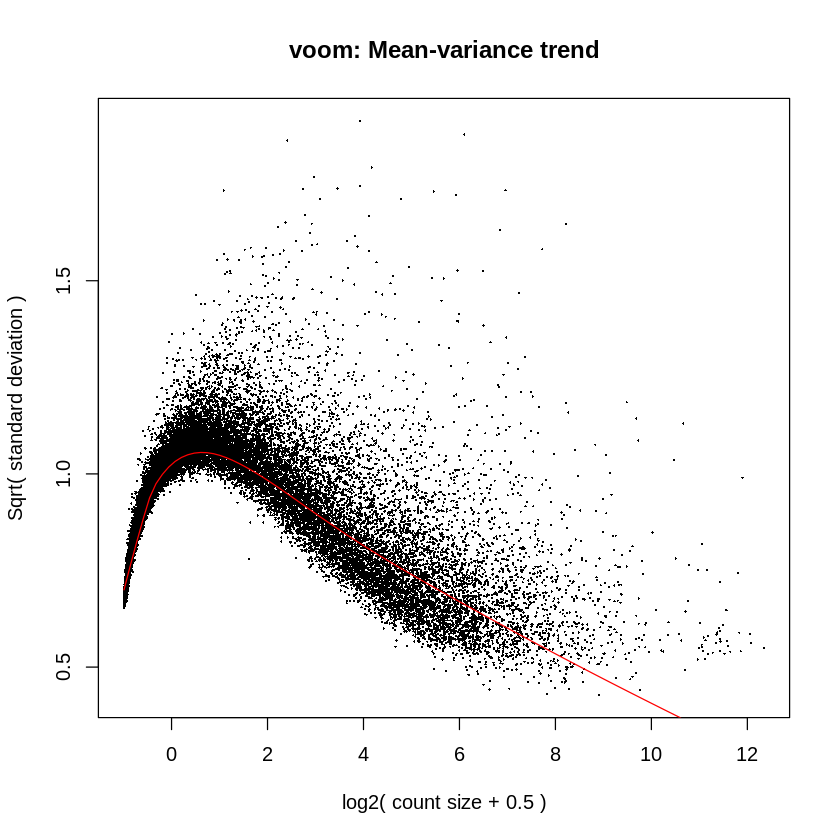

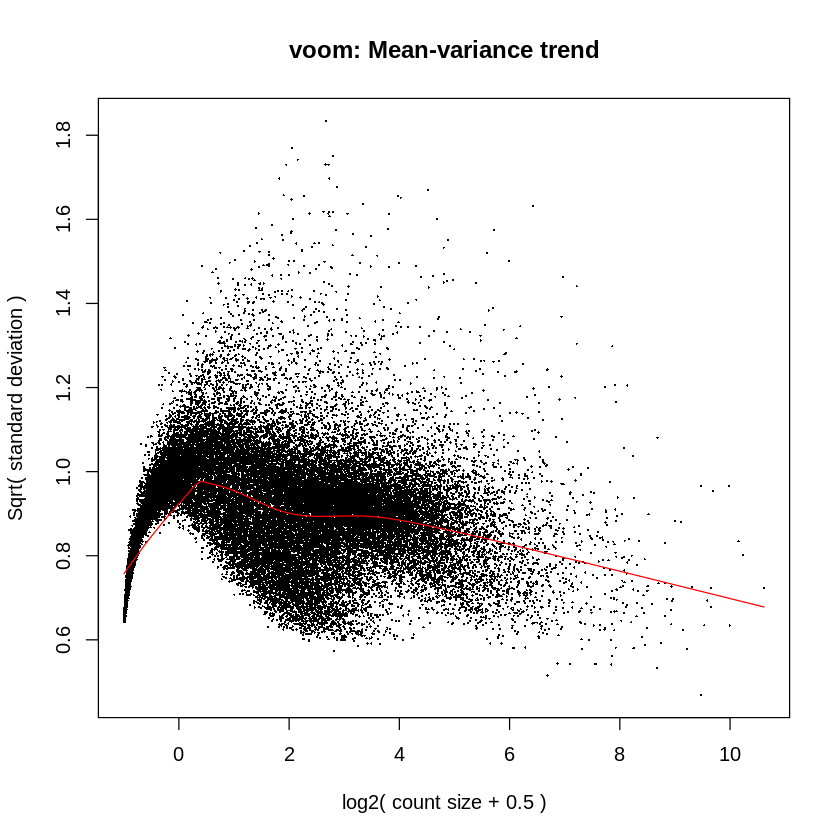

[1] 0

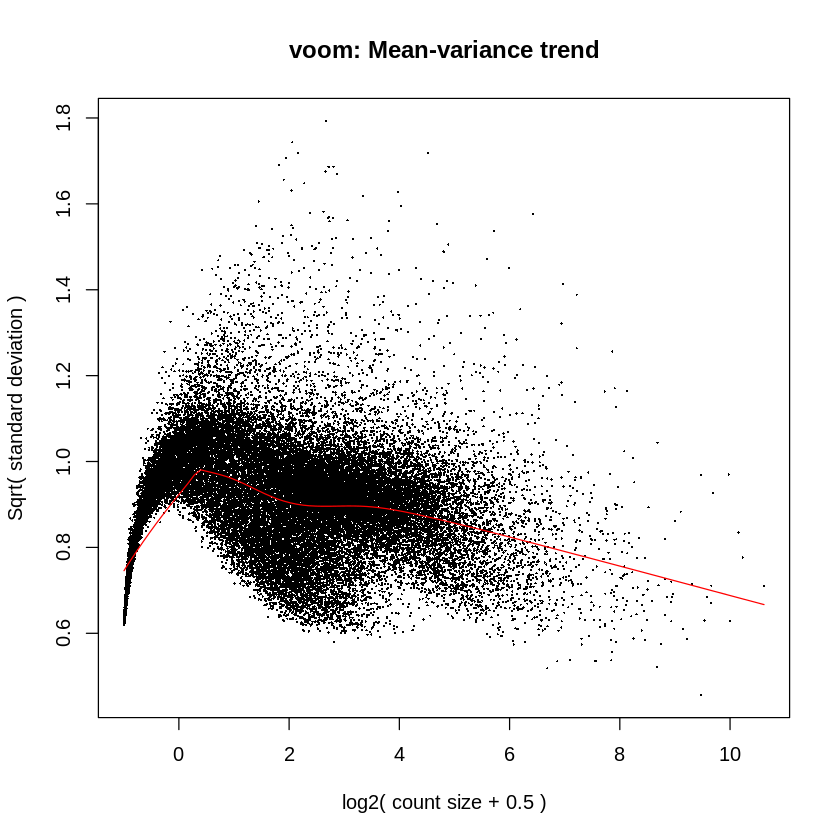

In [19]:
# tissue_index -- enables this to run as a NextFlow notebook

cat(levels(tissue_list_m_f),sep="\n")

actual_tissue_list_m_f = levels(tissue_list_m_f)
tissue_of_interest = actual_tissue_list_m_f[tissue_index]
tissue_of_interest
length(actual_tissue_list_m_f)
length(tissue_list_m_f)

dim(ijc_m_f_no_chrY)
dim(sjc_m_f_no_chrY)
dim(metadata_m_f)
dim(fromGTF_no_chrY)

print_exploratory_plots (tissue_of_interest, 
                         fromGTF_no_chrY, 
                         tissue_list_m_f, 
                         ijc_m_f_no_chrY, 
                         sjc_m_f_no_chrY, 
                         metadata_m_f )


## Metadata

For replicability and reproducibility purposes, we also print the following metadata:

1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

### 1. Checksums with the sha256 algorithm

In [20]:
rm (notebookid)
notebookid   = "AllTissueJunctionAnalysis"
notebookid

message("Generating sha256 checksums of the artefacts in the `..data/` directory .. ")
system(paste0("cd ../data && find . -type f -exec sha256sum {} \\;  >  ../metadata/", notebookid, "_sha256sums.txt"), intern = TRUE)
message("Done!\n")

paste0("../metadata/", notebookid, "_sha256sums.txt")

data.table::fread(paste0("../metadata/", notebookid, "_sha256sums.txt"), header = FALSE, col.names = c("sha256sum", "file"))

[1] "AllTissueJunctionAnalysis"

Generating sha256 checksums of the artefacts in the `..data/` directory .. 


character(0)

Done!



[1] "../metadata/AllTissueJunctionAnalysis_sha256sums.txt"

sha256sum,file
<chr>,<chr>
96daa446074412dab4e28f9d4af790456bbd3f59ed5f37e043f5600acdcc89dd,./liver_DGE.csv
d62cc9495ebc2198e8130fe5dc2d6924760125e938e6681cc01277310bd64438,./esophagus_muscularis_DGE.csv
a2ff5b941eaa7dc16c9f26e73d068108d7fc30bb33ee99bd7f5844623061577d,./signif_small_intestine_terminal_ileum.csv
05443ccebf5061786b851d4fe140c81c6b0dfbde84cefb489340233ce643c84c,./pituitary_DGE_refined.csv
e2f4f8e3ac9759572734c0fef7bb9008579624b95a772802324505ff30cad1bb,./brain_cortex_DGE_refined.csv
4f9c37e667fd691c619d395ffc8e3ff10e4d2f5beefd3912457a36eb2478ff15,./reduced_metadata_pData.csv
e514fd85f1b8025081699419761bb2813178f7143849a078b24ed36b8b37ff7a,./39_diff_splicing_tissues_with_header.csv
0f93f085571e67da7dfed0904901e3abd154005d418c2601fa85ddb67814b7d6,./results_dge_ijc_sex.tar.gz
980916646b8ab2a549129f8cc40cc87749629cf842b85dccefbe1e5f5506c152,./whole_blood_DGE_refined.csv


### 2. Libraries metadata

In [21]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", notebookid, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", notebookid ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]

Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..
Done!

Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..
Done!



 setting  value                       
 version  R version 3.6.1 (2019-07-05)
 os       Ubuntu 18.04.3 LTS          
 system   x86_64, linux-gnu           
 ui       X11                         
 language en_US.UTF-8                 
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2020-05-22                  

,package,ondiskversion,loadedversion,path,loadedpath,attached,is_base,date,source,md5ok,library
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<fct>
Biobase,Biobase,2.46.0,2.46.0,/opt/conda/lib/R/library/Biobase,/opt/conda/lib/R/library/Biobase,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
BiocGenerics,BiocGenerics,0.32.0,0.32.0,/opt/conda/lib/R/library/BiocGenerics,/opt/conda/lib/R/library/BiocGenerics,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
edgeR,edgeR,3.28.1,3.28.1,/opt/conda/lib/R/library/edgeR,/opt/conda/lib/R/library/edgeR,TRUE,FALSE,2020-02-26,Bioconductor,NA,/opt/conda/lib/R/library
limma,limma,3.42.0,3.42.0,/opt/conda/lib/R/library/limma,/opt/conda/lib/R/library/limma,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
multtest,multtest,2.42.0,2.42.0,/opt/conda/lib/R/library/multtest,/opt/conda/lib/R/library/multtest,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
piggyback,piggyback,0.0.10.99,0.0.10.99,/opt/conda/lib/R/library/piggyback,/opt/conda/lib/R/library/piggyback,TRUE,FALSE,2020-05-20,Github (ropensci/piggyback@87f71e8),NA,/opt/conda/lib/R/library
R.methodsS3,R.methodsS3,1.8.0,1.8.0,/opt/conda/lib/R/library/R.methodsS3,/opt/conda/lib/R/library/R.methodsS3,TRUE,FALSE,2020-02-14,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
R.oo,R.oo,1.23.0,1.23.0,/opt/conda/lib/R/library/R.oo,/opt/conda/lib/R/library/R.oo,TRUE,FALSE,2019-11-03,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
R.utils,R.utils,2.9.2,2.9.2,/opt/conda/lib/R/library/R.utils,/opt/conda/lib/R/library/R.utils,TRUE,FALSE,2019-12-08,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
